In [1]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_21860/2973097468.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,


In [2]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(3)
qubit_list = [0,1,2]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [3]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [4]:
# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [5]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(1):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [7]:
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [8]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.894 0.254 0.    0.    0.    0.    0.    0.   ]
 [0.106 0.746 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.891 0.263 0.    0.    0.    0.   ]
 [0.    0.    0.109 0.737 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.911 0.233 0.    0.   ]
 [0.    0.    0.    0.    0.089 0.767 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.9   0.251]
 [0.    0.    0.    0.    0.    0.    0.1   0.749]]


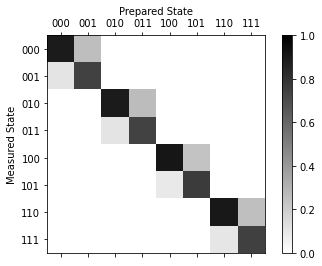

In [9]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [10]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.824375
Average Measurement Fidelity of Q0: 1.000000


# tomographyでどうか

In [12]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

In [19]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr)

qc.x([0,1])

# ghz.h(qr[0])
# ghz.cx(qr[0], qr[1])
# ghz.cx(qr[1], qr[2])
# ghz.measure(qr[0],cr[0])
# ghz.measure(qr[1],cr[1])
# ghz.measure(qr[2],cr[2])

st_qcs = state_tomography_circuits(qc, [0,1,2])

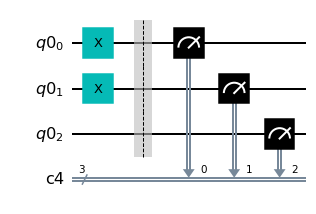

In [20]:
st_qcs[-1].draw("mpl")

In [21]:
job = qiskit.execute(st_qcs, backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

In [25]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

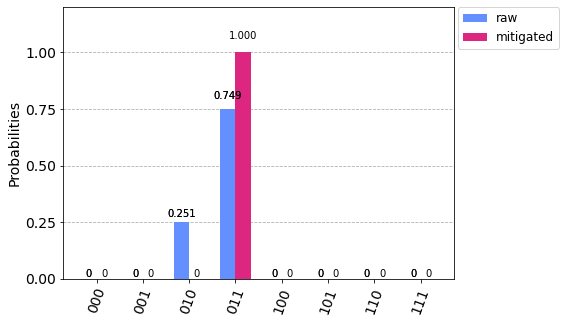

In [26]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts[-1], mitigated_counts[-1]], legend=['raw', 'mitigated'])

In [27]:
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

In [28]:
state_tomo(mitigated_results, st_qcs)

0.0007074516497627883

# 逆にしてみる

In [29]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr)

qc.x([0,1])

# ghz.h(qr[0])
# ghz.cx(qr[0], qr[1])
# ghz.cx(qr[1], qr[2])
# ghz.measure(qr[0],cr[0])
# ghz.measure(qr[1],cr[1])
# ghz.measure(qr[2],cr[2])

st_qcs = state_tomography_circuits(qc, [0,1,2][::-1])

In [31]:
job = qiskit.execute(st_qcs, backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

In [32]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

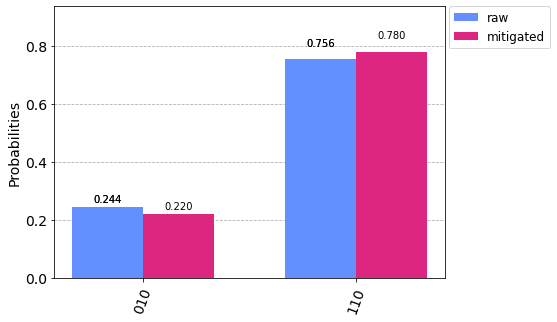

In [33]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts[-1], mitigated_counts[-1]], legend=['raw', 'mitigated'])

In [34]:
state_tomo(mitigated_results, st_qcs)

0.7466835754963999

In [35]:
state_tomo(results, st_qcs)

0.747402536679103